# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [6]:
brain_name

'BananaBrain'

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [7]:
# env_info = env.reset(train_mode=True)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [8]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [7]:
# For watching changes and reloading automatically
% load_ext autoreload
% autoreload 2

In [8]:
import json
with open("config.json", "r") as f:
    config = json.load(f)


In [9]:
config['trainer']['save_dir']

'./saved/'

In [10]:
# Imports
import os
import numpy as np
import torch
from collections import deque
from dqn_agent import Agent
import matplotlib.pyplot as plt

In [11]:
def choose_device(config, logger):
	""" Choose device """ 
	if config["cuda"] and not torch.cuda.is_available():
		logger.warning("Warning: There's no CUDA support on this machine,"
			"training is performed on cpu.")
		device = torch.device("cpu")
	elif not config["cuda"] and torch.cuda.is_available():
		logger.info("Training is performed on cpu by user's choice")
		device = torch.device("cpu")
	elif not config["cuda"] and not torch.cuda.is_available():
		logger.info("Training on cpu")
		device = torch.device("cpu")
	else:
		logger.info("Training on gpu")
		device = torch.device("cuda:" + str(config["gpu"]))	

	return device 

def check_dir(path):
	if not os.path.exists(path):
		os.makedirs(path)

In [12]:
# Create the agent
agent = Agent(state_size=37, action_size=4, config=config)

# BananaBrain
brain_name = env.brain_names[0]

# Main DQN function
def dqn(agent,
        brain_name,
        config,
        num_episodes=config["trainer"]["num_episodes"], 
        max_timesteps_per_ep=config["trainer"]["max_timesteps_per_ep"], 
        eps_start=config["GLIE"]["eps_start"], 
        eps_end=config["GLIE"]["eps_end"], 
        eps_decay=config["GLIE"]["eps_decay"]):
    
    """
    ---------------------
    Deep Q-Network
    ---------------------
    Params:
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon 
    
    """
    # When environment is technically solved
    flag = False 
    
    # Save path
    save_path = config["trainer"]["save_dir"] + config["exp_name"] + "/" 
    
    # list containing scores from each episodes
    scores = [] 
    scores_window = deque(maxlen=100)
    
    # initial epsilon val
    epsilon = eps_start
    
    for i_episode in range(1, num_episodes + 1):

        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # get the current state
        state = env_info.vector_observations[0]
        
        # initialize score to zero
        score = 0
        
        for ep in range(max_timesteps_per_ep):
            
            # select the action based on epsilon-greedy policy
            action = agent.act(state, epsilon) 
            
            # send the action to the environment
            env_info = env.step(action)[brain_name] 
            
            # get the next state
            next_state = env_info.vector_observations[0]
            
            # get the reward
            reward = env_info.rewards[0]
            
            # see if episode has finished 
            done = env_info.local_done[0]
            
            # take step 
            agent.step(state, action, reward, next_state, done)
            
            # score update (cumulative reward)
            score += reward
            
            # next state becomes the current state for next step
            state = next_state
            
            # exit loop
            if done: 
                break
                
        # Update epsilon 
        epsilon = max(eps_decay*epsilon, eps_end)
        
        # save most recent score
        scores.append(score)
        scores_window.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")

        if (i_episode % 100 == 0): 
            print("\rEpisode {}\tAverage Score: {:.3f}".format(i_episode, \
                                                               np.mean(scores_window)))
        
        # Save occasionnally
        if (i_episode % config["trainer"]["save_freq"] == 0):

            torch.save(agent.qnetwork_local.state_dict(), save_path + 
                config["trainer"]["save_trained_name"] + "_" + str(i_episode) + ".pth")
        
        # Check if environment is solved (if not already)
        if not flag:
            if (np.mean(scores_window) >= 13.0):
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
                i_episode-100, np.mean(scores_window)))        
                # Save solved model
                torch.save(agent.qnetwork_local.state_dict(), save_path + 
                        config["trainer"]["save_trained_name"] + "_solved.pth")

                flag = True
    
    return scores

scores = dqn(agent=agent, 
             brain_name=brain_name, 
             config=config)

INFO:Agent:Training on cpu
INFO:ReplayBuffer:Training on cpu


Episode 100	Average Score: 0.740
Episode 200	Average Score: 4.610
Episode 300	Average Score: 7.750
Episode 400	Average Score: 10.650
Episode 500	Average Score: 12.580
Episode 521	Average Score: 13.070
Environment solved in 421 episodes!	Average Score: 13.070
Episode 600	Average Score: 15.360
Episode 700	Average Score: 14.320
Episode 800	Average Score: 15.190
Episode 900	Average Score: 14.920
Episode 1000	Average Score: 15.430
Episode 1100	Average Score: 15.340
Episode 1200	Average Score: 16.490
Episode 1300	Average Score: 16.120
Episode 1400	Average Score: 16.030
Episode 1500	Average Score: 15.070
Episode 1600	Average Score: 15.390
Episode 1700	Average Score: 14.670
Episode 1800	Average Score: 15.800
Episode 1900	Average Score: 16.150
Episode 2000	Average Score: 15.230


In [13]:
config["trainer"]["save_dir"] + config["exp_name"] + "/" 

'./saved/DQN_exp/'

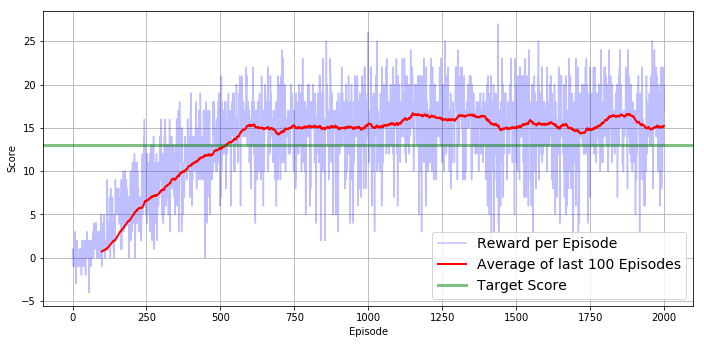

In [14]:
import pandas as pd
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

scores_rolling = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="blue", alpha=0.25)
ax.plot(scores_rolling, "-", c="red", linewidth=2)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(13, c="green", linewidth=3, alpha=0.5)
ax.legend(["Reward per Episode", "Average of last 100 Episodes", "Target Score"])

fig.tight_layout()
fig.savefig("plot.jpg")